In [1]:
import os
import random
import logging
import numpy as np
import pandas as pd

# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from tqdm import trange

import urllib.request
import pprint
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

from nltk import sent_tokenize, word_tokenize

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

pp = pprint.PrettyPrinter(indent=4)

In [2]:
local_rank = -1
max_seq_length = 40
bert_model = "bert-base-uncased"
do_lower_case = True
num_labels = 4
gradient_accumulation_steps = 1
train_batch_size = 32
eval_batch_size = 8
test_batch_size = 8
learning_rate = 5e-5
num_train_epochs = 3.0
warmup_proportion = 0.1
output_dir = "bert"
do_train = True
do_eval = True
fp16 = True
loss_scale = 0

In [3]:
if local_rank == -1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')

seed = 20190104

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

In [4]:
logger.info("device: {}, n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
    device, n_gpu, bool(local_rank != -1), fp16))

01/29/2019 11:11:20 - INFO - __main__ -   device: cuda, n_gpu: 2, distributed training: False, 16-bits training: True


## Tokenizer Comparison - NLTK Tokenizer vs BertTokenizer

In [5]:
sentences = [
    "I love Kung Fu Panda and chicken tikka masala!",
    "Divide each difficulty into as many parts as is feasible and necessary to resolve it.",
    "It is not enough to have a good mind; the main thing is to use it well.",
]

### NLTK Tokenizer

In [6]:
nltk_tokenized_text = [word_tokenize(sentence.lower()) for sentence in sentences]
pp.pprint(nltk_tokenized_text)

[   [   'i',
        'love',
        'kung',
        'fu',
        'panda',
        'and',
        'chicken',
        'tikka',
        'masala',
        '!'],
    [   'divide',
        'each',
        'difficulty',
        'into',
        'as',
        'many',
        'parts',
        'as',
        'is',
        'feasible',
        'and',
        'necessary',
        'to',
        'resolve',
        'it',
        '.'],
    [   'it',
        'is',
        'not',
        'enough',
        'to',
        'have',
        'a',
        'good',
        'mind',
        ';',
        'the',
        'main',
        'thing',
        'is',
        'to',
        'use',
        'it',
        'well',
        '.']]


### BertTokenizer

In [7]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)
bert_tokenized_text = [bert_tokenizer.tokenize(sentence) for sentence in sentences]
pp.pprint(bert_tokenized_text)

01/29/2019 11:11:23 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/david/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


[   [   'i',
        'love',
        'kung',
        'fu',
        'panda',
        'and',
        'chicken',
        'ti',
        '##kka',
        'mas',
        '##ala',
        '!'],
    [   'divide',
        'each',
        'difficulty',
        'into',
        'as',
        'many',
        'parts',
        'as',
        'is',
        'feasible',
        'and',
        'necessary',
        'to',
        'resolve',
        'it',
        '.'],
    [   'it',
        'is',
        'not',
        'enough',
        'to',
        'have',
        'a',
        'good',
        'mind',
        ';',
        'the',
        'main',
        'thing',
        'is',
        'to',
        'use',
        'it',
        'well',
        '.']]


## Data Preprocessing

In [8]:
label_list = ["anger", "sadness", "joy"]
label_map = {label : i for i, label in enumerate(label_list)}
logger.info(label_map)

01/29/2019 11:11:23 - INFO - __main__ -   {'anger': 0, 'sadness': 1, 'joy': 2}


In [9]:
class EmoIntDataset(object):
    BASE_URL = "http://saifmohammad.com/WebDocs/"
    TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
    TEST_URI = "EmoInt%20Test%20Gold%20Data/{}-ratings-0to1.test.gold.txt"
    THRESHOLD = 0.33
  
    def get_labels(self):
        return ["anger", "fear", "joy", "sadness"]
  
    def get_label_map(self):
        return {label : i for i, label in enumerate(self.get_labels())}

    def __load_data_per_class(self, label, url, threshold=0):
        resource = urllib.request.urlopen(url)
        np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
        df = pd.DataFrame(np_array, columns=["id", "text", "label", "label_level"])
        df['label_level'] = df['label_level'].astype(float)
        df = df.query('label_level>' + str(threshold))
        df.loc[df["label"] == label, "label_int"] = self.get_label_map()[label]
        return df[["text", "label", "label_int"]]
    
    def __load_data(self, set_threshold=False):
        train_data = None
        test_data = None

        for label in self.get_labels():
            # load train dataset
            train_df = self.__load_data_per_class(label, self.BASE_URL + self.TRAIN_URI.format(label), threshold=(self.THRESHOLD if set_threshold else 0))

            # load test dataset
            test_df = self.__load_data_per_class(label, self.BASE_URL + self.TEST_URI.format(label), threshold=(self.THRESHOLD if set_threshold else 0))

            train_data = (train_df if train_data is None else train_data.append(train_df))
            test_data = (test_df if test_data is None else test_data.append(test_df))

        return train_data, test_data

    def __init__(self, set_threshold=False):
        self.train_dataset, self.test_dataset = self.__load_data(set_threshold)

In [10]:
dataset = EmoIntDataset(set_threshold=True)
train_dataset = dataset.train_dataset 
test_dataset = dataset.test_dataset
train_dataset, eval_dataset = train_test_split(train_dataset, test_size=0.1, random_state=41, stratify=train_dataset.label)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
print("train_dataset.shape: (%d, %d)" % train_dataset.shape)
print("eval_dataset.shape: (%d, %d)" % eval_dataset.shape)
print("test_dataset.shape: (%d, %d)" % test_dataset.shape)

train_dataset.shape: (2610, 3)
eval_dataset.shape: (291, 3)
test_dataset.shape: (2508, 3)


In [14]:
for (row_index, row) in train_dataset.iterrows():
    logger.info("row index:{}".format(row_index))
    logger.info("text:{}".format(row.text))
    logger.info("label:{}".format(row.label))
    logger.info("label_int:{}".format(row.label_int))
    break

01/29/2019 11:12:56 - INFO - __main__ -   row index:123
01/29/2019 11:12:56 - INFO - __main__ -   text:Food that gets delivered 😍🙌🏻  
01/29/2019 11:12:56 - INFO - __main__ -   label:joy
01/29/2019 11:12:56 - INFO - __main__ -   label_int:2.0


In [15]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        
def convert_dataset_to_features(dataset, label_map, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    index = 0
    for (guid, row) in dataset.iterrows():
        tokens = tokenizer.tokenize(row.text)

        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[row.label]
        if index < 5:
            logger.info("*** row ***")
            logger.info("guid: %s" % (guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (row.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
        index += 1
        
    return features


def _truncate_seq_pair(tokens, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens) > len(tokens_b):
            tokens.pop()
        else:
            tokens_b.pop()

In [16]:
train_features = convert_dataset_to_features(train_dataset, dataset.get_label_map(), max_seq_length, bert_tokenizer)

01/29/2019 11:12:58 - INFO - __main__ -   *** row ***
01/29/2019 11:12:58 - INFO - __main__ -   guid: 123
01/29/2019 11:12:58 - INFO - __main__ -   tokens: [CLS] food that gets delivered [UNK] [SEP]
01/29/2019 11:12:58 - INFO - __main__ -   input_ids: 101 2833 2008 4152 5359 100 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/29/2019 11:12:58 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/29/2019 11:12:58 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/29/2019 11:12:58 - INFO - __main__ -   label: joy (id = 2)
01/29/2019 11:12:58 - INFO - __main__ -   *** row ***
01/29/2019 11:12:58 - INFO - __main__ -   guid: 700
01/29/2019 11:12:58 - INFO - __main__ -   tokens: [CLS] @ the _ nasty _ p now you gotta do that with fast n furious [SEP]
01/29/2019 11:12:58 - INFO - __main__ -   input_ids: 101 1030 1996 1035 11808 1035 1052 208

In [21]:
logger.info("train_features length:{}".format(len(train_features)))

01/29/2019 11:14:07 - INFO - __main__ -   train_features length:2610


In [17]:
eval_features = convert_dataset_to_features(eval_dataset, dataset.get_label_map(), max_seq_length, bert_tokenizer)

01/29/2019 11:12:59 - INFO - __main__ -   *** row ***
01/29/2019 11:12:59 - INFO - __main__ -   guid: 471
01/29/2019 11:12:59 - INFO - __main__ -   tokens: [CLS] lord make me an instrument of your peace — where there ' s hate , let me so ##w love — where there ' s injury , pardon — where there ' s despair , hope [SEP]
01/29/2019 11:12:59 - INFO - __main__ -   input_ids: 101 2935 2191 2033 2019 6602 1997 2115 3521 1517 2073 2045 1005 1055 5223 1010 2292 2033 2061 2860 2293 1517 2073 2045 1005 1055 4544 1010 14933 1517 2073 2045 1005 1055 13905 1010 3246 102 0 0
01/29/2019 11:12:59 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
01/29/2019 11:12:59 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/29/2019 11:12:59 - INFO - __main__ -   label: sadness (id = 3)
01/29/2019 11:12:59 - INFO - __main__ -   *** row ***
01/29/2019 11:12:59 - INFO - __main__ -   gu

In [22]:
logger.info("eval_features length:{}".format(len(eval_features)))

01/29/2019 11:14:20 - INFO - __main__ -   eval_features length:291


In [18]:
test_features = convert_dataset_to_features(test_dataset, dataset.get_label_map(), max_seq_length, bert_tokenizer)

01/29/2019 11:13:00 - INFO - __main__ -   *** row ***
01/29/2019 11:13:00 - INFO - __main__ -   guid: 2
01/29/2019 11:13:00 - INFO - __main__ -   tokens: [CLS] this game has pissed me off more than any other game this year . my blood is boiling ! time to turn it off ! # st ##lc ##ards [SEP]
01/29/2019 11:13:00 - INFO - __main__ -   input_ids: 101 2023 2208 2038 9421 2033 2125 2062 2084 2151 2060 2208 2023 2095 1012 2026 2668 2003 16018 999 2051 2000 2735 2009 2125 999 1001 2358 15472 18117 102 0 0 0 0 0 0 0 0 0
01/29/2019 11:13:00 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
01/29/2019 11:13:00 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/29/2019 11:13:00 - INFO - __main__ -   label: anger (id = 0)
01/29/2019 11:13:00 - INFO - __main__ -   *** row ***
01/29/2019 11:13:00 - INFO - __main__ -   guid: 4
01/29/2019 11:13:00 - INFO - __main__ -   toke

In [23]:
logger.info("test_features length:{}".format(len(test_features)))

01/29/2019 11:14:36 - INFO - __main__ -   test_features length:2508


In [19]:
# Prepare model
model = BertForSequenceClassification.from_pretrained(
    bert_model,
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(local_rank),
    num_labels = num_labels
)
model.to(device)

if fp16:
    model.half()
        
if local_rank != -1:
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    model = DDP(model)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

01/29/2019 11:13:02 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/david/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
01/29/2019 11:13:02 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/david/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpc0qm87dz
01/29/2019 11:13:06 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers":

In [24]:
param_optimizer = list(model.named_parameters())

In [25]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

train_batch_size = int(train_batch_size / gradient_accumulation_steps)
logger.info("train_batch_size = {}".format(train_batch_size))
logger.info("num train_dataset = {}".format(len(train_dataset)))
logger.info("gradient_accumulation_steps = {}".format(gradient_accumulation_steps))
logger.info("num_train_epochs = {}".format(num_train_epochs))

num_train_steps = int(
    len(train_dataset) / train_batch_size / gradient_accumulation_steps * num_train_epochs
)
logger.info("num_train_steps = {}".format(num_train_steps))

t_total = num_train_steps

if local_rank != -1:
    t_total = t_total // torch.distributed.get_world_size()

logger.info("t_total = {}".format(t_total))

01/29/2019 11:14:45 - INFO - __main__ -   train_batch_size = 32
01/29/2019 11:14:45 - INFO - __main__ -   num train_dataset = 2610
01/29/2019 11:14:45 - INFO - __main__ -   gradient_accumulation_steps = 1
01/29/2019 11:14:45 - INFO - __main__ -   num_train_epochs = 3.0
01/29/2019 11:14:45 - INFO - __main__ -   num_train_steps = 244
01/29/2019 11:14:45 - INFO - __main__ -   t_total = 244


In [26]:
if fp16:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    optimizer = FusedAdam(optimizer_grouped_parameters,
                          lr=learning_rate,
                          bias_correction=False,
                          max_grad_norm=1.0)
    if loss_scale == 0:
        optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
    else:
        optimizer = FP16_Optimizer(optimizer, static_loss_scale=loss_scale)

else:
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=learning_rate,
                         warmup=warmup_proportion,
                         t_total=t_total)

In [27]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0
    
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_dataset))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)
train_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
train_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
train_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
train_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

01/29/2019 11:14:47 - INFO - __main__ -   ***** Running training *****
01/29/2019 11:14:48 - INFO - __main__ -     Num examples = 2610
01/29/2019 11:14:48 - INFO - __main__ -     Batch size = 32
01/29/2019 11:14:48 - INFO - __main__ -     Num steps = 244


In [28]:
train_input_ids

tensor([[  101,  2833,  2008,  ...,     0,     0,     0],
        [  101,  1030,  1996,  ...,     0,     0,     0],
        [  101,  4067,  2643,  ...,     0,     0,     0],
        ...,
        [  101,  5037,  4654,  ...,     0,     0,     0],
        [  101,  1045,  1005,  ...,     0,     0,     0],
        [  101, 10126,  5637,  ...,  2890, 10222,   102]])

In [29]:
train_input_ids[0]

tensor([ 101, 2833, 2008, 4152, 5359,  100,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [30]:
train_input_ids.shape

torch.Size([2610, 40])

In [31]:
train_input_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])

In [32]:
train_input_mask[0]

tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
train_input_mask.shape

torch.Size([2610, 40])

In [34]:
train_segment_ids

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [35]:
train_segment_ids[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
train_segment_ids.shape

torch.Size([2610, 40])

In [37]:
train_label_ids

tensor([2, 0, 1,  ..., 2, 0, 1])

In [38]:
train_label_ids[0]

tensor(2)

In [39]:
train_label_ids.shape

torch.Size([2610])

In [40]:
train_data = TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label_ids)
if local_rank == -1:
    train_sampler = RandomSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

In [41]:
train_sampler

In [42]:
logger.info("num_train_epochs = {}".format(num_train_epochs))

01/29/2019 11:14:56 - INFO - __main__ -   num_train_epochs = 3.0


In [43]:
def calc_accuracy(preds, labels):
    return np.sum(preds == labels)

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [44]:
model.train()
for _ in trange(int(num_train_epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        train_input_ids, train_input_mask, train_segment_ids, train_label_ids = batch
        loss = model(train_input_ids, train_segment_ids, train_input_mask, train_label_ids)
        if n_gpu > 1:
            loss = loss.mean() # mean() to average on multi-gpu.
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
            
        if fp16:
            optimizer.backward(loss)
        else:
            loss.backward()
            
        tr_loss += loss.item()
        nb_tr_examples += train_input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % gradient_accumulation_steps == 0:
            # modify learning rate with special warm up BERT uses
            lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

train_loss = tr_loss/nb_tr_steps if do_train else None

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



Grad overflow on iteration 0
Using dynamic loss scale of 4294967296

Grad overflow on iteration 1
Using dynamic loss scale of 2147483648.0

Grad overflow on iteration 2
Using dynamic loss scale of 1073741824.0

Grad overflow on iteration 3
Using dynamic loss scale of 536870912.0

Grad overflow on iteration 4
Using dynamic loss scale of 268435456.0

Grad overflow on iteration 5
Using dynamic loss scale of 134217728.0

Grad overflow on iteration 6
Using dynamic loss scale of 67108864.0

Grad overflow on iteration 7
Using dynamic loss scale of 33554432.0

Grad overflow on iteration 8
Using dynamic loss scale of 16777216.0

Grad overflow on iteration 9
Using dynamic loss scale of 8388608.0

Grad overflow on iteration 10
Using dynamic loss scale of 4194304.0

Grad overflow on iteration 11
Using dynamic loss scale of 2097152.0

Grad overflow on iteration 12
Using dynamic loss scale of 1048576.0

Grad overflow on iteration 13
Using dynamic loss scale of 524288.0

Grad overflow on iteration 1

Epoch:  33%|███▎      | 1/3 [00:28<00:56, 28.12s/it]


Grad overflow on iteration 82
Using dynamic loss scale of 8192.0


Epoch:  67%|██████▋   | 2/3 [00:52<00:26, 26.86s/it]

Epoch: 100%|██████████| 3/3 [01:15<00:00, 25.96s/it]


In [46]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = "pytorch_emoint_bert_model.pt"
torch.save(model_to_save.state_dict(), output_model_file)

# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForSequenceClassification.from_pretrained(bert_model, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

01/29/2019 11:16:25 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/david/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
01/29/2019 11:16:25 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/david/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpxjatxdqu
01/29/2019 11:16:29 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=T

## Evaluate the model

In [47]:
def evaluate(mode, features, batch_size):
    logger.info("***** Running {} *****".format(mode))
    logger.info("  Num examples = %d", len(features))
    logger.info("  Batch size = %d", batch_size)
    
    input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(input_ids, input_mask, segment_ids, label_ids)
    
    # Run prediction for full data
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    model.eval()
    loss, accuracy = 0, 0
    nb_steps, nb_examples = 0, 0
    all_pred_label_ids = []
    all_actual_label_ids = []

    for input_ids, input_mask, segment_ids, label_ids in tqdm(dataloader, desc=mode):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            tmp_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        logits = logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=1)
        
        label_ids = label_ids.to('cpu').numpy()
        
        all_pred_label_ids += preds.tolist()
        all_actual_label_ids += label_ids.tolist()
        
        tmp_accuracy = calc_accuracy(preds, label_ids)

        loss += tmp_loss.mean().item()
        accuracy += tmp_accuracy

        nb_examples += input_ids.size(0)
        nb_steps += 1

    loss = loss / nb_steps
    accuracy = accuracy / nb_examples
    
    result = {'{}_loss'.format(mode): loss,
              '{}_accuracy'.format(mode): accuracy,
              'global_step': global_step}

    output_file = "pytorch_emoint_bert_{}_results.txt".format(mode)
    with open(output_file, "w") as writer:
        logger.info("***** {} results *****".format(mode))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return loss, accuracy, all_pred_label_ids, all_actual_label_ids

In [48]:
eval_result = evaluate('eval', eval_features, eval_batch_size)
eval_loss, eval_accuracy, eval_pred_label_ids, eval_actual_label_ids = eval_result

01/29/2019 11:16:32 - INFO - __main__ -   ***** Running eval *****
01/29/2019 11:16:32 - INFO - __main__ -     Num examples = 291
01/29/2019 11:16:32 - INFO - __main__ -     Batch size = 8


01/29/2019 11:16:34 - INFO - __main__ -   ***** eval results *****
01/29/2019 11:16:34 - INFO - __main__ -     eval_accuracy = 0.872852233676976
01/29/2019 11:16:34 - INFO - __main__ -     eval_loss = 0.38137887055809433
01/29/2019 11:16:34 - INFO - __main__ -     global_step = 246


In [49]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(eval_actual_label_ids, eval_pred_label_ids)

df_cm = pd.DataFrame(
    cf_matrix, index=dataset.get_labels(), columns=dataset.get_labels(), 
)

df_cm

,anger,fear,joy,sadness
anger,63,5,4,1
fear,3,84,1,4
joy,5,1,58,0
sadness,6,7,0,49


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Figure(288x216)


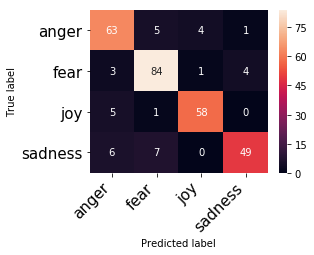

In [51]:
print(print_confusion_matrix(cf_matrix, class_names=dataset.get_labels()))

In [52]:
precision, recall, fscore, support = precision_recall_fscore_support(eval_actual_label_ids, eval_pred_label_ids)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=dataset.get_labels())
score_df

,precision,recall,f1-score,support
anger,0.8182,0.8630,0.8400,73
fear,0.8660,0.9130,0.8889,92
joy,0.9206,0.9062,0.9134,64
sadness,0.9074,0.7903,0.8448,62


In [53]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(eval_actual_label_ids, eval_pred_label_ids)
print("kappa:", kappa_score)

kappa: 0.8284307476575945


## Test the model

In [54]:
test_result = evaluate('test', test_features, test_batch_size)
test_loss, test_accuracy, test_pred_label_ids, test_actual_label_ids = test_result

01/29/2019 11:16:34 - INFO - __main__ -   ***** Running test *****
01/29/2019 11:16:34 - INFO - __main__ -     Num examples = 2508
01/29/2019 11:16:34 - INFO - __main__ -     Batch size = 8


01/29/2019 11:16:44 - INFO - __main__ -   ***** test results *****
01/29/2019 11:16:44 - INFO - __main__ -     global_step = 246
01/29/2019 11:16:44 - INFO - __main__ -     test_accuracy = 0.8548644338118022
01/29/2019 11:16:44 - INFO - __main__ -     test_loss = 0.45134367762952093


In [55]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(test_actual_label_ids, test_pred_label_ids)

df_cm = pd.DataFrame(
    cf_matrix, index=dataset.get_labels(), columns=dataset.get_labels(), 
)

df_cm

,anger,fear,joy,sadness
anger,550,47,13,33
fear,66,649,16,58
joy,19,20,493,11
sadness,43,33,5,452


Figure(288x216)


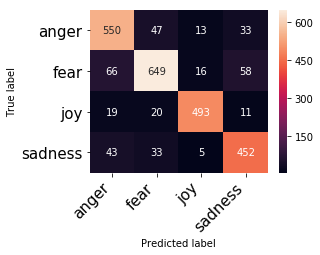

In [56]:
print(print_confusion_matrix(cf_matrix, class_names=dataset.get_labels()))

In [57]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_label_ids, test_pred_label_ids)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=dataset.get_labels())
score_df

,precision,recall,f1-score,support
anger,0.8112,0.8554,0.8327,643
fear,0.8665,0.8226,0.8440,789
joy,0.9355,0.9079,0.9215,543
sadness,0.8159,0.8480,0.8316,533


In [58]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_label_ids, test_pred_label_ids, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8549,0.8549,0.8549,None


In [59]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(test_actual_label_ids, test_pred_label_ids)
print("kappa:", kappa_score)

kappa: 0.8050044150572462
